## K-Means Clustering for Heart Disease Analysis 

## Introduction

Clustering is a unsupervised learning algorithm that automatically organizes data into groups. It's unsupervised because the algorithm figures out the groups on its own, without any pre-defined categories. This is useful for finding hidden patterns in data, like grouping customers with similar shopping habits or in this case grouping patients with similar diagnosis.


**Heart disease, also known as cardiovascular disease (CVD)**, is an umbrella term for conditions affecting the heart and blood vessels. This includes coronary artery disease, heart attacks, arrhythmias, and heart failure. Early diagnosis is critical. It allows for prompt treatment, which can significantly reduce the risk of complications like heart attacks and improve overall health outcomes. Identifying risk factors like high blood pressure, cholesterol, diabetes, and unhealthy lifestyle habits early is key. This allows for timely intervention through lifestyle changes and medications. Regular check-ups and being aware of potential symptoms are crucial for early detection, leading to better management of the disease and a better quality of life for those affected.


### Dataset
The data used for this learning was obtained from V.A. Medical Center in Long Beach, California, publicly available on Kaggle, https://www.kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis. The objective was to examine patients and cluster for heart disease diagnosis


*A little headsup: I am terrible with naming just incase you see really weird variable names.*




In [90]:
#import Libraries
import matplotlib.pyplot as plt
from zipfile import ZipFile
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from kmodes.kprototypes import KPrototypes
from kneed import KneeLocator




### Unzip and Load the data

In [2]:
#load the data
file_name = "k-means-clustering-for-heart-disease-analysis.zip"
spec_file = "heart_disease.csv"
with ZipFile(file_name) as f:
    with f.open(spec_file) as s:
        df = pd.read_csv(s)
print("df shape:", df.shape)
df.head()

df shape: (920, 15)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


### Explore Data

In [3]:
#Explore the data
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB
None
(920, 15)


In [4]:
#copy out data for analysis
df1 = df.copy()
#deleting column with null set greater than 200
Huge_null = df1.isna().sum()
columns_to_drop = Huge_null[Huge_null > 100].index 
print(columns_to_drop)
df1.drop(columns_to_drop, axis = 1, inplace = True)

Index(['slope', 'ca', 'thal'], dtype='object')


In [5]:
print(df1.isna().sum())

id           0
age          0
sex          0
dataset      0
cp           0
trestbps    59
chol        30
fbs         90
restecg      2
thalch      55
exang       55
oldpeak     62
dtype: int64


#### Data Cleaning

- Number of Rows present in data: 920
- Number of Columns present: 15
- Variable Types:
   - Numerical (6): These represents quantitative measurements related to heart health (e.g., age, blood pressure,    cholesterol levels).
   - Categorical (8): These represent qualitative information, likely with predefined categories (e.g., gender, smoking status, family history of heart disease).

Three columns _slope, ca and thal_ was removed because of high  null values present
- Formed a new dataframe here, **df1**, incase I need to revert back to my orifinal dataframe for further insight.

### Exploratory Data Analysis

In [6]:
#deleting rows with null set
df1.dropna(inplace = True)
print("df1 shape:",df1.shape)
df1_num = df1.select_dtypes(include = "number")
print("df1_num shape:",df1_num.shape)
#df1["id"] = df1['id'].astype("category")
df1_cat = df1.select_dtypes(exclude = "number")
print("df1_cat shape:",df1_cat.shape)
print(df1_cat.head(3))
print()
print(df1_num.head(3))

df1 shape: (740, 12)
df1_num shape: (740, 6)
df1_cat shape: (740, 6)
    sex    dataset              cp    fbs         restecg  exang
0  Male  Cleveland  typical angina   True  lv hypertrophy  False
1  Male  Cleveland    asymptomatic  False  lv hypertrophy   True
2  Male  Cleveland    asymptomatic  False  lv hypertrophy   True

   id  age  trestbps   chol  thalch  oldpeak
0   0   63     145.0  233.0   150.0      2.3
1   1   67     160.0  286.0   108.0      1.5
2   2   67     120.0  229.0   129.0      2.6


#### Exploring categorical columns

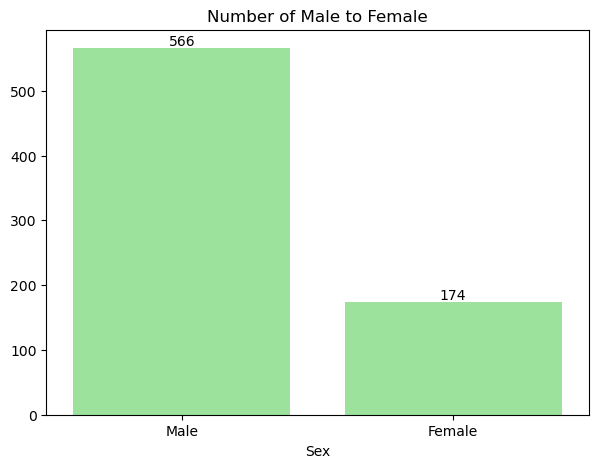

In [7]:
plt.figure(figsize=(7, 5))
counts = sns.countplot(x='sex', data=df1_cat, color = "lightgreen") 
plt.bar_label(counts.containers[0])
plt.title('Number of Male to Female')
plt.xlabel('Sex')
plt.ylabel('')
plt.show()

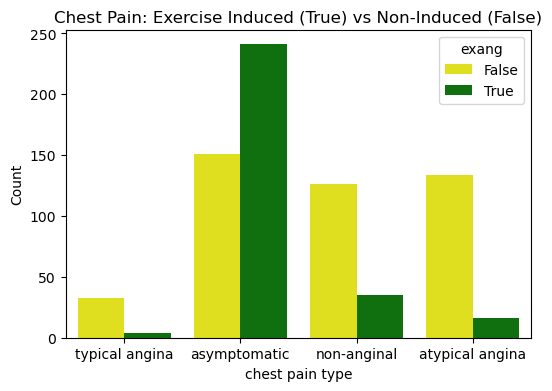

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(data = df1_cat ,x = 'cp', hue = 'exang', palette = ["yellow","green"]) 
plt.title('Chest Pain: Exercise Induced (True) vs Non-Induced (False)')
plt.xlabel('chest pain type')
plt.ylabel('Count')
plt.show()

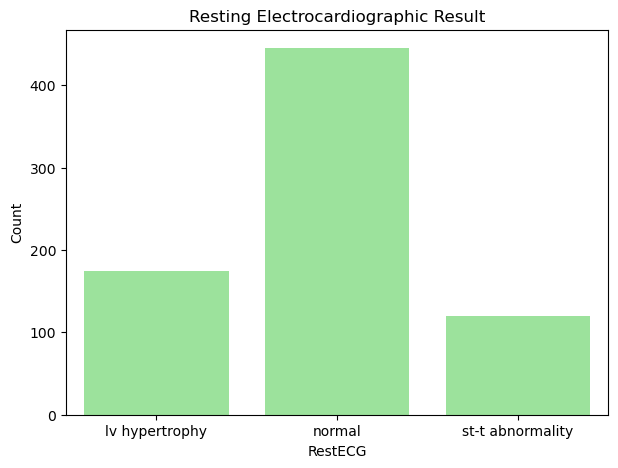

In [9]:
plt.figure(figsize=(7, 5))
sns.countplot(x='restecg', data=df1_cat,color = "lightgreen" ) 
plt.title('Resting Electrocardiographic Result')
plt.xlabel('RestECG')
plt.ylabel('Count')
plt.show()

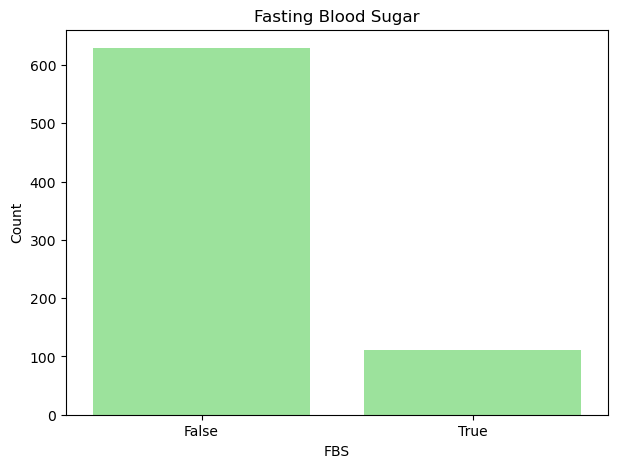

In [10]:
plt.figure(figsize=(7, 5))
sns.countplot(x='fbs', data=df1_cat,color = "lightgreen" ) 
plt.title('Fasting Blood Sugar')
plt.xlabel('FBS')
plt.ylabel('Count')
plt.show()

#### Exploring numerical columns

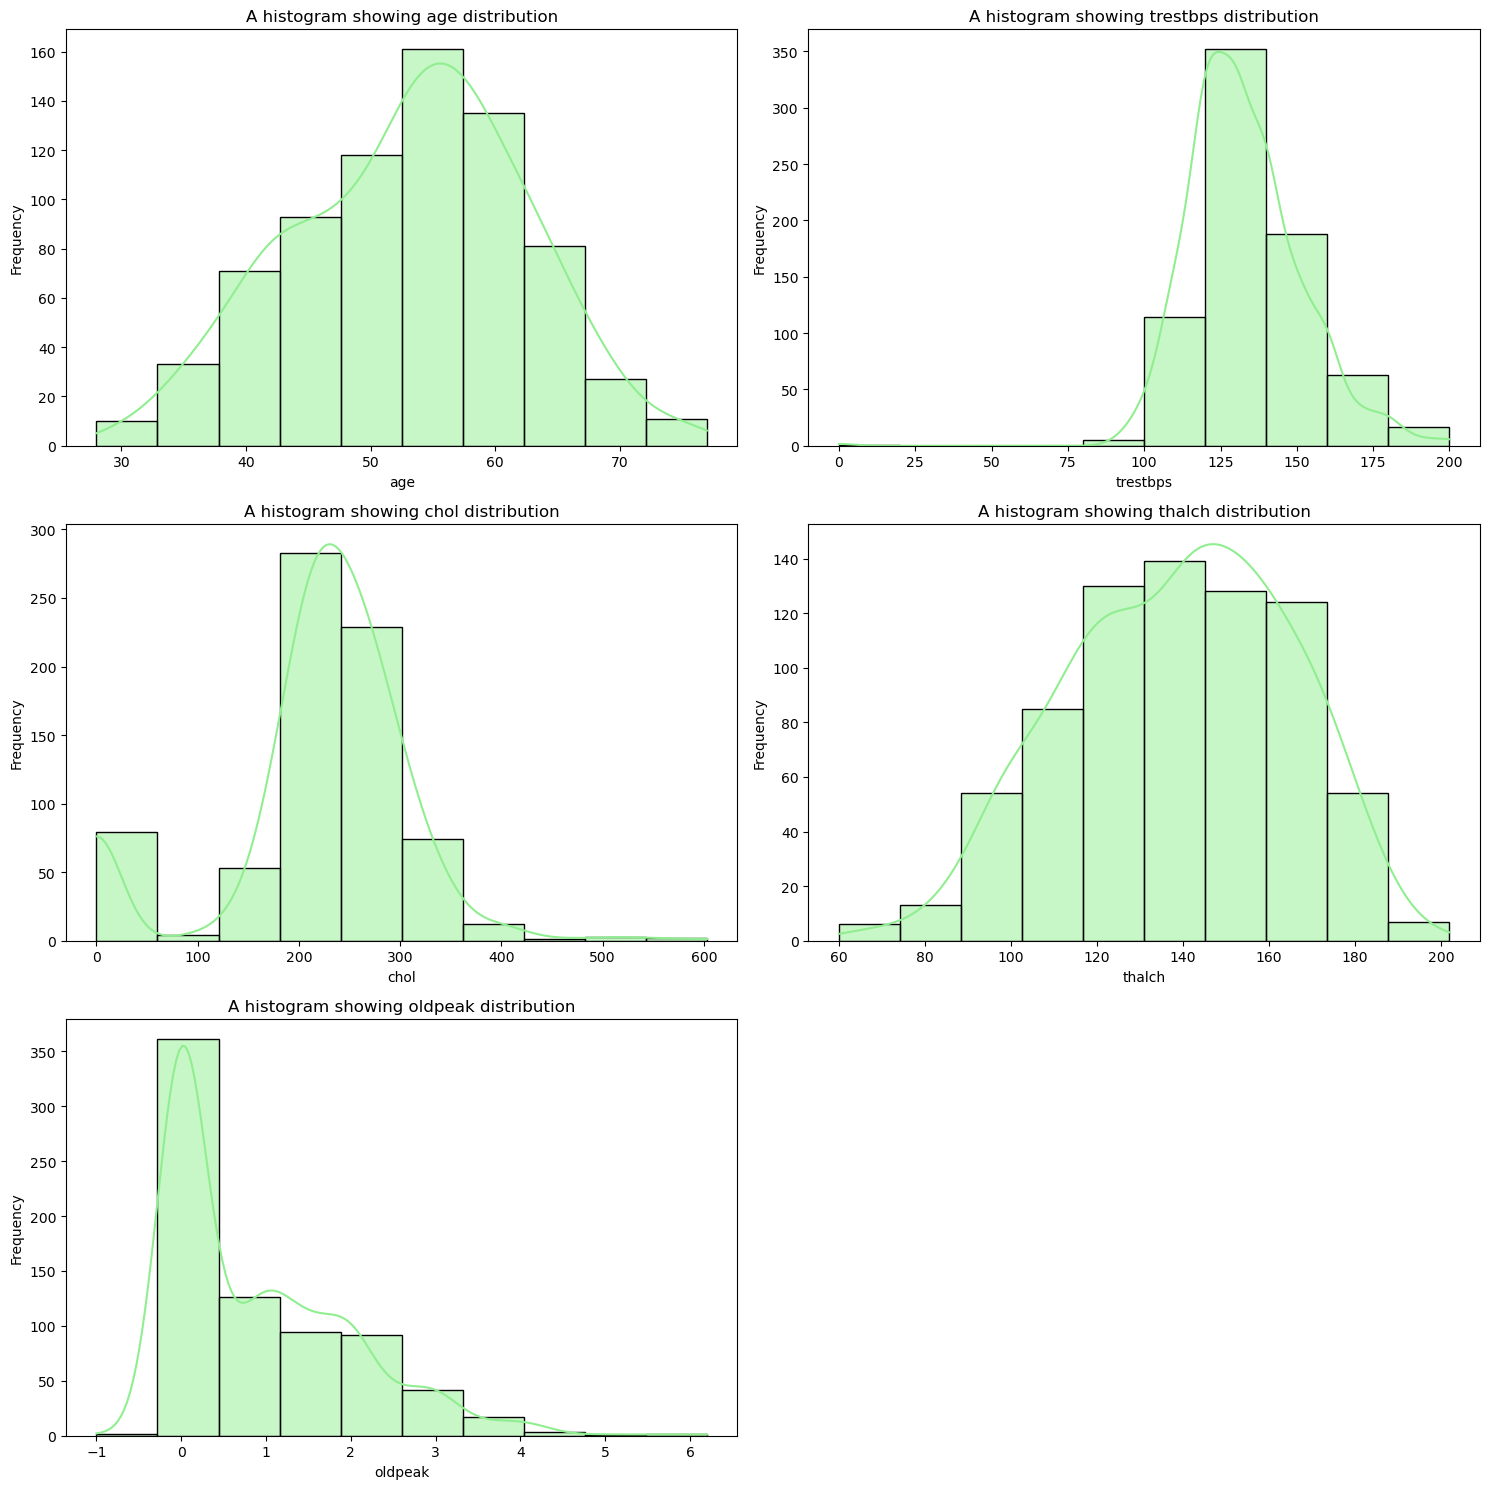

In [11]:
df2_num = df1_num.drop("id", axis = 1)
plt.figure(figsize=(15,15))
for i, col in enumerate(df2_num.columns):
    plt.subplot(3, 2, i+1)  # Create subplot for each column
    sns.histplot(df2_num[col], kde = True, color='lightgreen', bins=10)
    plt.title(f'A histogram showing {col} distribution')
    plt.ylabel('Frequency')
    
plt.tight_layout() 
plt.show()

In [12]:
corr = df2_num.corr()
corr.style.background_gradient(axis = None)

,age,trestbps,chol,thalch,oldpeak
age,1.000000,0.251817,-0.068419,-0.367020,0.251741
trestbps,0.251817,1.000000,0.060759,-0.121594,0.182027
chol,-0.068419,0.060759,1.000000,0.196281,0.060660
thalch,-0.367020,-0.121594,0.196281,1.000000,-0.181867
oldpeak,0.251741,0.182027,0.060660,-0.181867,1.000000


In [13]:
age_chol = (df1_num
            .groupby("age")
            .chol.mean()
            .rename("Chol_Mean")
            .to_frame()
            .reset_index()
           )
print("age_chol shape:", age_chol.shape)


age_thal = (df1_num
            .groupby("age")
            .thalch.mean()
            .rename("Chol_Mean")
            .to_frame()
            .reset_index()
           )
print("age_thal shape:", age_thal.shape)

age_chol shape: (50, 2)
age_thal shape: (50, 2)


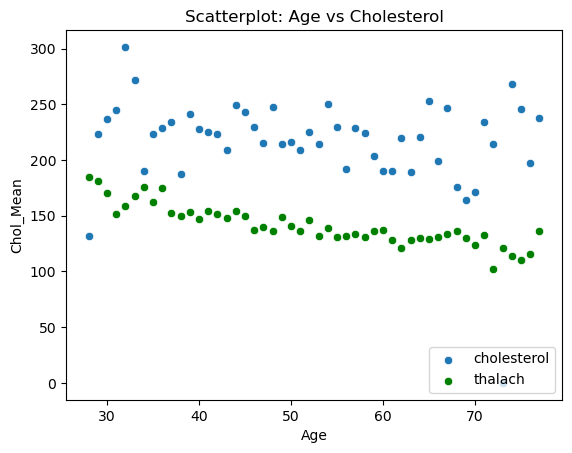

In [14]:
sns.scatterplot(data = age_chol, x = "age",y = "Chol_Mean");
plt.title('Scatterplot: Age vs Cholesterol')
plt.xlabel("Age")

sns.scatterplot(data = age_thal, x = "age",y = "Chol_Mean", color = "green");
plt.title('Scatterplot: Age vs Cholesterol')
plt.xlabel("Age")

plt.legend(["cholesterol", "thalach"], loc="lower right");

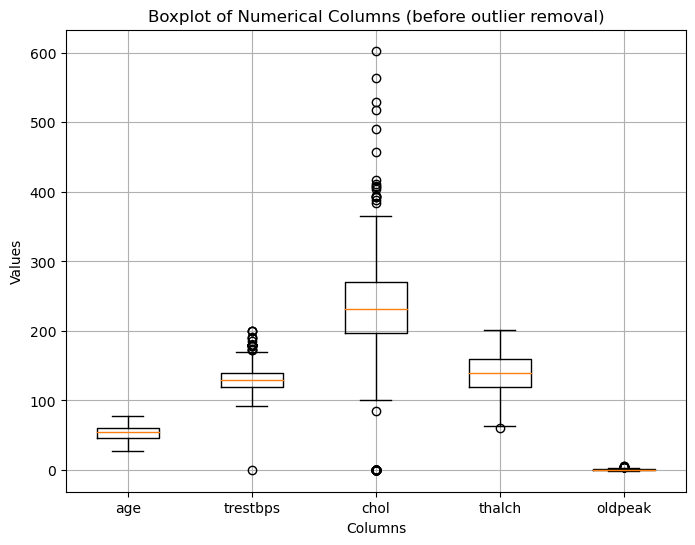

In [15]:
plt.figure(figsize=(8, 6))
plt.boxplot(df2_num.values, labels=df2_num.columns)
plt.title('Boxplot of Numerical Columns (before outlier removal)')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.grid(True)
plt.show()


In [16]:
def iqr_outliers(df, columns):
    df2 = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        df2 = df2[(df2[col] >= lower_bound) & (df2[col] <= upper_bound)]
    return df2

# List of columns to analyze

df3_num = iqr_outliers(df1_num, df2_num.columns)
print("Data now have", df3_num.shape[0], "rows")
print()
print(df3_num.head())

Data now have 613 rows

   id  age  trestbps   chol  thalch  oldpeak
0   0   63     145.0  233.0   150.0      2.3
1   1   67     160.0  286.0   108.0      1.5
2   2   67     120.0  229.0   129.0      2.6
3   3   37     130.0  250.0   187.0      3.5
4   4   41     130.0  204.0   172.0      1.4


In [17]:
unique_values = df3_num["id"].unique()

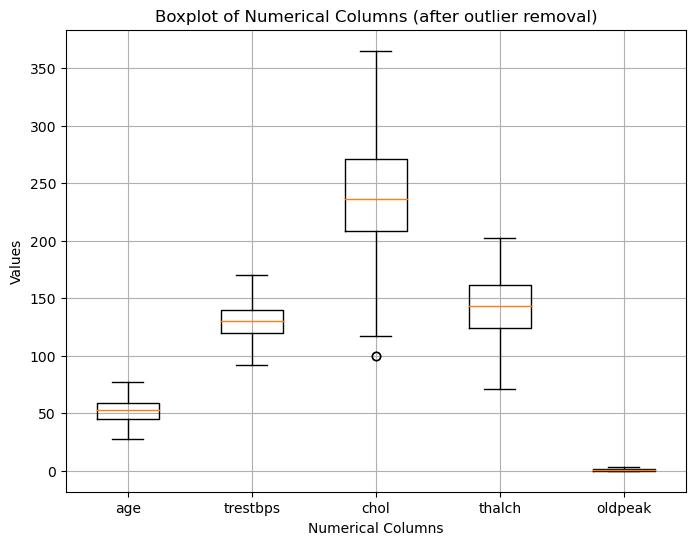

In [18]:
df4_num = df3_num.drop('id', axis = 1)
plt.figure(figsize=(8, 6))
plt.boxplot(df4_num.values, labels=df4_num.columns)
plt.title('Boxplot of Numerical Columns (after outlier removal)')
plt.xlabel('Numerical Columns')
plt.ylabel('Values')
plt.grid(True)
plt.show()

### Data Analysis

Analysis your data is beneficial to building to building a great model.  To help me further I demarcated the dataset into numerical columns and categorical columns. On analysis of **categorical columns**, I found out that:
- The data contained more male than female (566: 174). 
- The scecond chart(grouped bar chart) showed that a greater number of persons had asymptomatic angina. It is also interesting to note that greater percentage of asympotomatc angina are exercised-induced. Note:Asymptomatic angina, also known as silent angina or silent ischemia, is a condition where the heart muscle receives insufficient blood flow (and thus, oxygen) without the individual experiencing any noticeable symptoms. Absence of symptoms can be dangerous because individuals may not seek medical attention until a more serious event.
- Most had a normal ECG, followed by LVhypertrophy and about st-t abnormality. {Explain}
- Most paersons recorded has a Fasting blood sugar less than 120mg/dl (False). Fasting blood sugar is

**Numerical data**:
- The patients were typically between the age of 30 and 74. 
- The numerical variables had little or no less correlation with one another (Correlation co-efficint < +-0.5. Though on further analysis (scatter plot), there was a slight negative correlation between age and maximum heart rate (thalach). It was noted that as age increases, there seemed to be a decrease in maximum heart rate achieved. A couple of reasons might be the physicological cause For example, loss of muscle vigor.
- The **boxplot** was done to visualise the presence of outliers. Outliers are data points in a set that differs significantly from the rest of the data. They could be very high or low values. These could skew the model performance hence it is advisable to remove them. However, we run a risk of loosing potential data values and valuable information 




### Feature Engineering

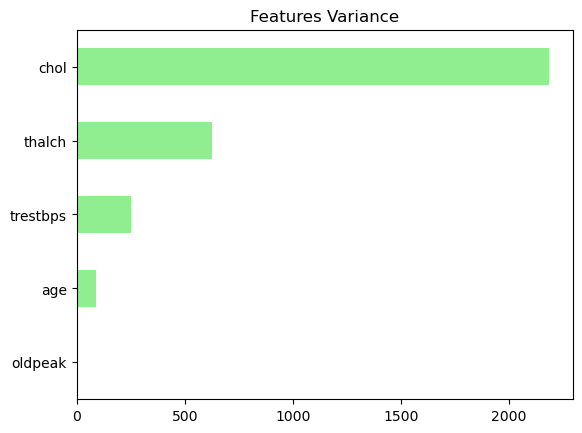

In [19]:
feat = df4_num.var().sort_values()
ax = feat.plot(kind = "barh", color = "lightgreen")
plt.title("Features Variance")
plt.show()


In [62]:
var_index = df3_num.columns.drop(["oldpeak"]).to_list()
var_index

['id', 'age', 'trestbps', 'chol', 'thalch']

In [113]:
cat_index = ["cp", "restecg", "fbs"]
col = var_index + cat_index 
comb_data = df1[col]
print("Initial DataFrame (comb_data):")
print(comb_data.shape)
comb_data = comb_data[comb_data['id'].isin(unique_values)]
print("\nDataFrame (df1) filtered based on unique values from filtered outlier dataframe(df3_num):")
print(comb_data.shape)
comb_data.drop("id",axis =1, inplace = True)
print("\nRemoving the id column:")
print(comb_data.shape)
comb_data

Initial DataFrame (comb_data):
(740, 8)

DataFrame (df1) filtered based on unique values from filtered outlier dataframe(df3_num):
(613, 8)

Removing the id column:
(613, 7)


,age,trestbps,chol,thalch,cp,restecg,fbs
0,63,145.0,233.0,150.0,typical angina,lv hypertrophy,True
1,67,160.0,286.0,108.0,asymptomatic,lv hypertrophy,False
2,67,120.0,229.0,129.0,asymptomatic,lv hypertrophy,False
3,37,130.0,250.0,187.0,non-anginal,normal,False
4,41,130.0,204.0,172.0,atypical angina,lv hypertrophy,False
...,...,...,...,...,...,...,...
913,62,158.0,170.0,138.0,asymptomatic,st-t abnormality,False
914,46,134.0,310.0,126.0,asymptomatic,normal,False
915,54,127.0,333.0,154.0,asymptomatic,st-t abnormality,True
917,55,122.0,223.0,100.0,asymptomatic,st-t abnormality,True


In [114]:
num_cols = comb_data.select_dtypes(exclude = "object").columns
cat_cols = comb_data.select_dtypes(include = "object").columns
print(cat_cols)
cd_data = comb_data.copy() 
scaler = MinMaxScaler()

cd_data[num_cols] = scaler.fit_transform(cd_data[num_cols])

X = pd.concat([cd_data[num_cols], cd_data[cat_cols]], axis=1)


Index(['cp', 'restecg', 'fbs'], dtype='object')


In [115]:
#getting the position of the categorical data
cat_col_pos = [X.columns.get_loc(col) for col in list(comb_data.select_dtypes('object').columns)]
print("categorical column:", list(X.select_dtypes('object').columns))
print("categorical columns position", cat_col_pos)
      

categorical column: ['cp', 'restecg', 'fbs']
categorical columns position [4, 5, 6]


In [116]:
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Index: 613 entries, 0 to 919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       613 non-null    float64
 1   trestbps  613 non-null    float64
 2   chol      613 non-null    float64
 3   thalch    613 non-null    float64
 4   cp        613 non-null    object 
 5   restecg   613 non-null    object 
 6   fbs       613 non-null    object 
dtypes: float64(4), object(3)
memory usage: 38.3+ KB


,age,trestbps,chol,thalch,cp,restecg,fbs
0,0.714286,0.679487,0.501887,0.603053,typical angina,lv hypertrophy,True
1,0.795918,0.871795,0.701887,0.282443,asymptomatic,lv hypertrophy,False
2,0.795918,0.358974,0.486792,0.442748,asymptomatic,lv hypertrophy,False
3,0.183673,0.487179,0.566038,0.885496,non-anginal,normal,False
4,0.265306,0.487179,0.392453,0.770992,atypical angina,lv hypertrophy,False


#### Feature Engineering

Feature engineering is the process of creating or selecting features for machine learning models. A good engineered feature can enhance the accuracy and efficiency of a model. Domain Knowledge plays a role here in properly selecting important features

For KPrototype model, Choosing high-variance variables for k-means clustering is beneficial because these variables capture significant differences between data points, leading to clearer, more meaningful clusters. They improve the accuracy and efficiency of the clustering process by highlighting distinctive features and reducing noise. I removed *oldpeak* because of its low variance.

Standardization of numerical columns was done to avoid scale-related bias. Model like Kmeans is sensitive to the scale of the input variables

### Model Building

In [117]:
#Finding the best cluster
n_cluster = range(1,10)
cost = []
for k in n_cluster:
    model = KPrototypes(n_jobs = -1, n_clusters = k, init = "Huang", random_state = 1)
    comb_data['target'] = model.fit_predict(X, categorical = cat_col_pos)
    cost.append(model.cost_)
    
print("Cost Type:", type(cost))
print("Cost Len:", len(cost))
print("Cost:", cost)
    
    

Cost Type: <class 'list'>
Cost Len: 9
Cost: [150.07503908877084, 122.95846968837743, 110.00373067463887, 101.53912768213434, 96.2588952631035, 89.46008587414545, 85.30875689249798, 82.29418306421121, 78.59154561801594]


Text(0, 0.5, 'Cost')

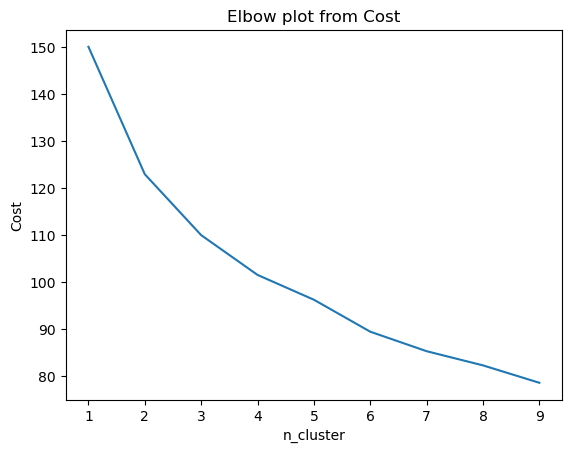

In [118]:
#Elbow plot
sns.lineplot(x = n_cluster, y = cost);
plt.title("Elbow plot from Cost" )
plt.xlabel("n_cluster")
plt.ylabel('Cost')

In [119]:
#Build  the model
model = KPrototypes(n_jobs = -1, n_clusters = 2, init = "Huang", random_state = 42)
comb_data['target'] = model.fit_predict(X, categorical = cat_col_pos)
    
 


<Axes: xlabel='target'>

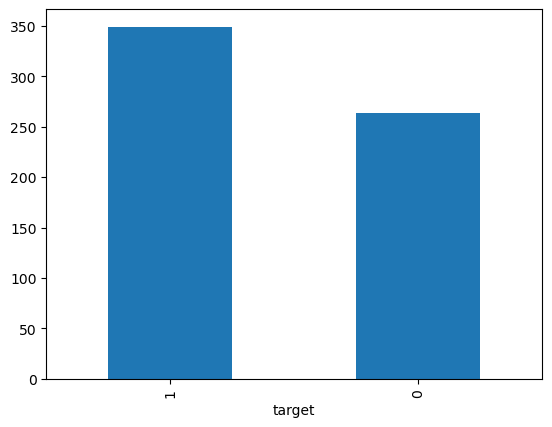

In [120]:
comb_data["target"].value_counts().plot(kind = "bar")

In [121]:
num_class = comb_data[[ "age","trestbps", "thalch", "chol","target"]].groupby('target').mean()
print("Num_class type", type(num_class))
num_class.head()

Num_class type <class 'pandas.core.frame.DataFrame'>


,age,trestbps,thalch,chol
target,,,,
0,45.662879,125.208333,159.125000,233.412879
1,57.401146,135.361032,128.575931,245.977077


Text(0.5, 1.0, 'Numerical : Potential Diagnosis Cluster ')

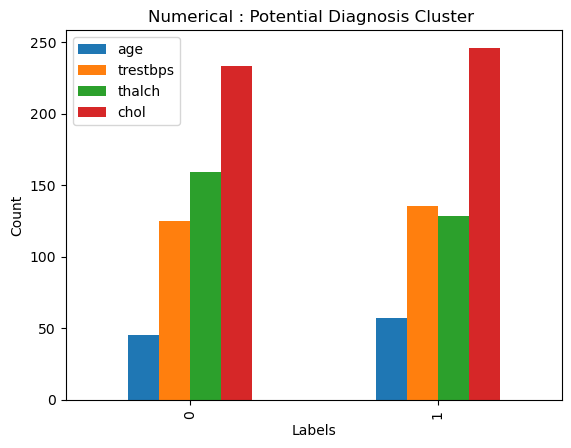

In [127]:
num_class.plot(kind = "bar")
plt.xlabel('Labels') 
plt.ylabel('Count')  # Set y-axis label
plt.title('Numerical : Potential Diagnosis Cluster ')

In [123]:
#picking out 2 variables
model.cluster_centroids_

array([['0.3604669140383425', '0.4257478632478633', '0.503444825614637',
        '0.6727099236641219', 'atypical angina', 'normal', 'False'],
       ['0.6000233904450035', '0.555910660495187', '0.550856895712818',
        '0.4395109254358148', 'asymptomatic', 'normal', 'False']],
      dtype='<U32')

In [124]:
def create_pivot_table_with_plot(data, columns = cat_index):
    for col in columns:
        pivot_table = data.pivot_table(index= col, columns= "target", aggfunc='size',fill_value = 0)

  # Normalize by total for each index level
        pivot_table = pivot_table.div(pivot_table.sum(axis=1), axis=0)
    #melt it
        print(f"{col} table: \n{pivot_table}")
  # Create pandas plot
        pivot_table.plot(kind='bar',  stacked=False)  # Stacked=False for separate bars
        plt.xlabel(f"{col}")
        plt.ylabel("Normalized Frequency")
        plt.title(f"Cluster by {col}")
#plt.legend(title=index_col)  # Add legend with index column name
        plt.show()  # Optional: Show the plot if you don't intend to use it elsewhere

    return 




cp table: 
target                  0         1
cp                                 
asymptomatic     0.143813  0.856187
atypical angina  0.846154  0.153846
non-anginal      0.615942  0.384058
typical angina   0.454545  0.545455


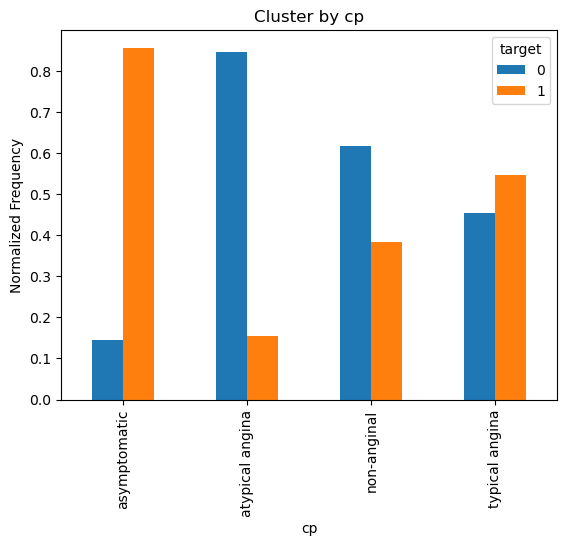

restecg table: 
target                   0         1
restecg                             
lv hypertrophy    0.333333  0.666667
normal            0.503979  0.496021
st-t abnormality  0.275000  0.725000


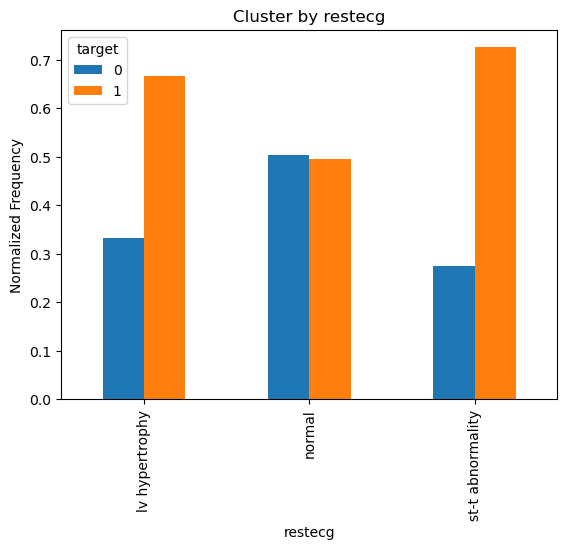

fbs table: 
target         0         1
fbs                       
False   0.464762  0.535238
True    0.227273  0.772727


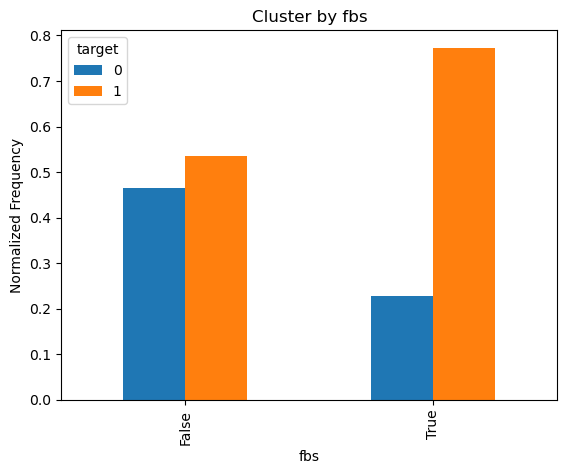

In [125]:
create_pivot_table_with_plot(comb_data)

### Insight from Data


**Data and Clustering:**

* The model used seven features: Age, Cholesterol (Chol), resting blood pressure (trestps), maximum heart rate (thalach), chest pain type (cp), resting electrocardiographic results (restecg), and fasting blood sugar (fbs).
* The model identified two clusters:
    * Cluster 0: Likely representing individuals with a negative diagnosis of cardiovascular disease (CVD).
    * Cluster 1: Likely representing individuals with a positive diagnosis of CVD.

**Risk Factors and Cluster Distribution:**

* **Age, Blood Pressure and Cholesterol:** These were found to be higher on average in patients within the 1-cluster (positive diagnosis). This aligns with established risk factors for CVD, where cumulative exposure over time increases the likelihood of disease. Additionally, physiological changes, co-existing health conditions, lifestyle factors, and hormonal influences associated with aging can contribute further.
* **Maximum Heart Rate (trestbp):** Interestingly, the analysis revealed a lower average heart rate in the 1-cluster (positive diagnosis) for older individuals (>50). This could be due to physiological adaptations in response to chronic heart issues, where the heart becomes less efficient at pumping blood.

**Chest Pain Type and Cluster Distribution:**

* Atypical angina and non-angina chest pain were more prevalent in the 0-cluster (negative diagnosis). This makes sense as these pain types can be caused by conditions other than CVD.
* Typical angina and asymptomatic patients were more frequent in the 1-cluster (positive diagnosis). This aligns with the known presentation of coronary heart disease (CHD), where silent ischemia (asymptomatic) is quite common.

**Electrocardiogram (ECG) and Cluster Distribution:**

* Patients with a normal ECG were more likely to fall under the 0-cluster (negative diagnosis). Conversely, those with left ventricular hypertrophy (LVH) and ST-T wave abnormalities were more prevalent in the 1-cluster (positive diagnosis). This is a strong indicator, as LVH and ST-T abnormalities are significant markers of potential heart disease.

**Fasting Blood Sugar (FBS) and Cluster Distribution:**

* Individuals with fasting blood sugar exceeding 120mg/dl (considered diabetic) were more likely to be clustered as positive for CVD (cluster 1). Diabetes is a known risk factor for CVD, accelerating the atherosclerotic process (plaque buildup in arteries) and contributing to vascular damage through inflammation and oxidative stress. 

**Additional Considerations:**

* It's important to note that this analysis is based on a limited set of features (7 columns).  Including additional data points like blood pressure (trestbp) could strengthen the model and potentially refine the cluster distribution.
* Further investigation is needed to determine the specific thresholds used for risk factors like cholesterol and blood sugar.
* While the model provides insights into potential CVD diagnosis based on these features, it is not a definitive diagnostic tool. 

